## Load and clean data 

In [1]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()
df.head()

2025-12-17 09:37:43.725 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


The data comes from the following sources:
70.28 % from halide perovskites,
0.0277 % from chalcogenides perovskites,
29.70 % from chalcogenide semiconductors


,reduced_formulas,descriptive_formulas,bandgap,source
0,CH6I3NPb,MAPbI3,1.6,pvk
2,CH6I3NPb,MAPbI3,1.5,pvk
3,CH6I3NPb,MAPbI3,1.6,pvk
4,CH6I3NPb,MAPbI3,1.6,pvk
5,CH6I3NPb,MAPbI3,1.6,pvk


### Group Repeated Formulas

The dataset contains many repeated formulas and corresponding bandgap values. To make sure each formula is unique, we will use the `groupby_formula` function from CrabNet to group entries by their formulas and use the mean values for their bandgap. We make a new final DataFrame for our model, call it **df_reduced_formula** and adjust colum names etc.

Let's rename columns and use the `gourpby_formula` function from CrabNet:

In [3]:
from crabnet.utils.data import groupby_formula  # type: ignore
from tf_chpvk_pv.modeling.CrabNet.utils import save_processed_data
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df.rename(columns={'bandgap': 'target'}, inplace=True)
df.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df, how='median')
df_grouped_formula.head()

save_processed_data(df_grouped_formula)

2025-12-17 09:39:47.233 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:save_processed_data:56 - Processed data saved to /home/dagar/TF-ChPVK-PV/data/interim/df_grouped_formula_complete_dataset.csv


Let's check the shape of the DataFrame we would like to use for our ML:

In [4]:
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

for formula in df_grouped_formula['formula']:
    df_grouped_formula.loc[df_grouped_formula['formula'] == formula, 'source'] = df.loc[df['formula'] == formula, 'source'].values[0]

sc_percent = (df_grouped_formula.source.value_counts() / df_grouped_formula.shape[0] * 100).to_dict()
sources = [sc_percent.get(sc) for sc in ['pvk', 'chalcogenides', 'chalc_semicon']]

txt = 'After cleaning and groupin the data, the sources percentages are:' \
      '\n{0:.2f} % from halide perovskites,' \
      '\n{1:.4f} % from chalcogenides perovskites,' \
      '\n{2:.2f} % from chalcogenide semiconductors'.format(*sources)
print(txt)
df_grouped_formula.drop(columns=['source'], inplace=True)

The shape of the DataFrame is:  (3605, 3)
After cleaning and groupin the data, the sources percentages are:
27.68 % from halide perovskites,
0.3051 % from chalcogenides perovskites,
72.01 % from chalcogenide semiconductors


### Pettifor features

Let's add the pettifor features based on the grouped_formula to improve the training process. This function already separates the data in 3, being 80% for training, 10% for validation and 10% for test. This separation is done taking into account the source imbalance by stratifyng based on this feature.

In [5]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df)

### Check Element Prevalence 

We will use `pymatviz` ([link to docs](https://pymatviz.janosh.dev/)) for visualizing the element prevalence.

<Axes: >

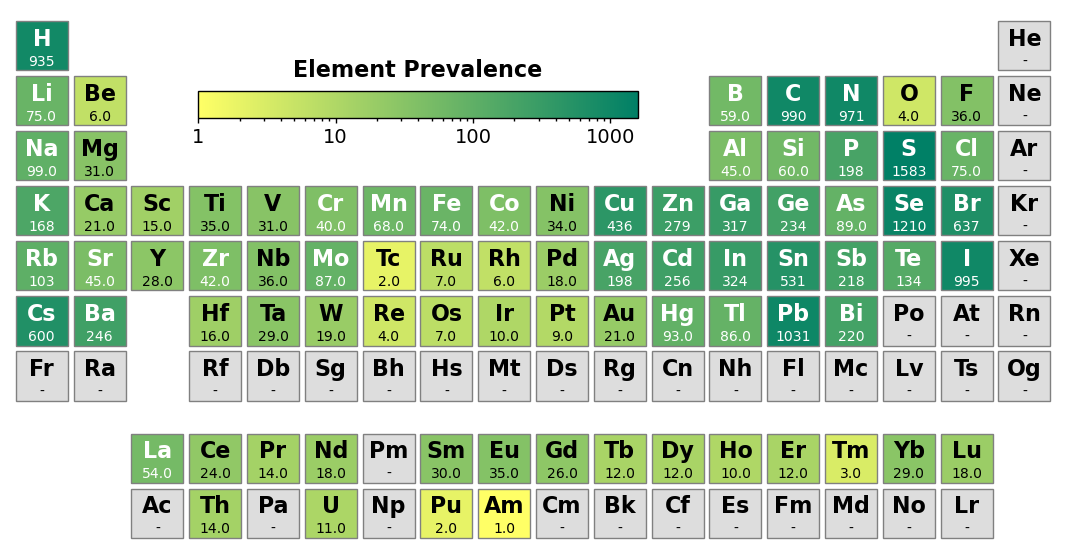

In [6]:
from pymatviz import count_elements, ptable_heatmap
import re

element_counts = count_elements([re.sub(r'\d+', '', x).replace('.', '') for x in df_grouped_formula['formula']])

# Plot the periodic table heatmap
ptable_heatmap(element_counts, log=True, cbar_title='Element Prevalence')

Let's continue and build the model in the next section!

## Build and Fit the Model 

We then fit the model using the CrabNet implementation.


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2884/2884 [00:00<00:00, 109956.03formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 360/360 [00:00<00:00, 127799.36formulae/s]


loading data with up to 8 elements in the formula
stepping every 230 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.587 val mae: 0.59


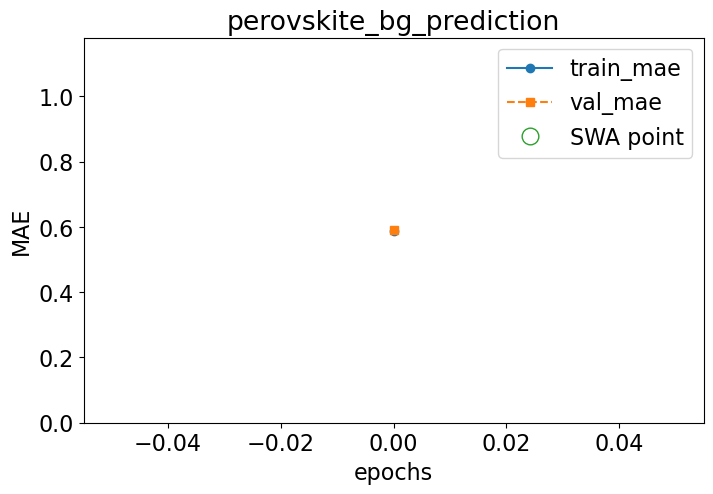

Epoch: 19/300 --- train mae: 0.262 val mae: 0.379


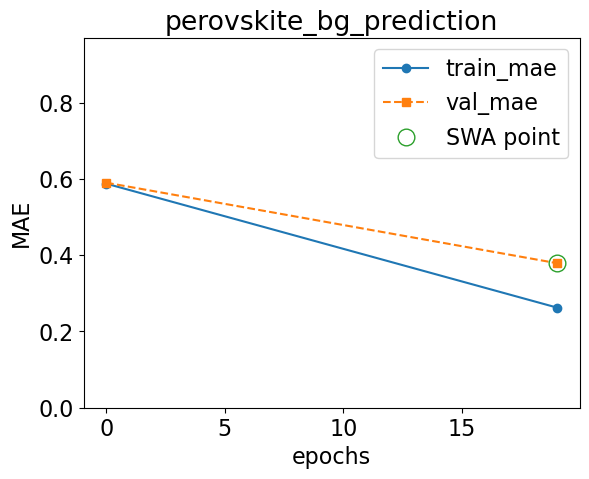

Epoch: 39/300 --- train mae: 0.163 val mae: 0.369


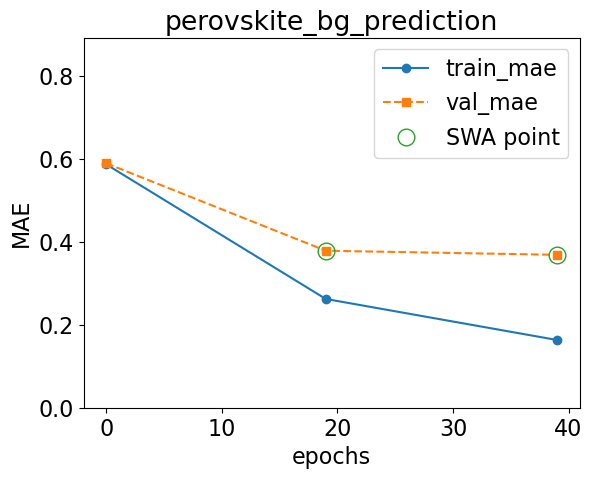

Epoch: 59/300 --- train mae: 0.112 val mae: 0.37


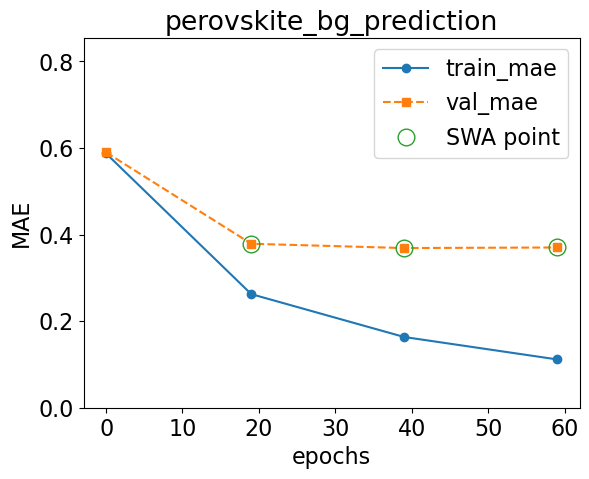

Epoch: 79/300 --- train mae: 0.0805 val mae: 0.367


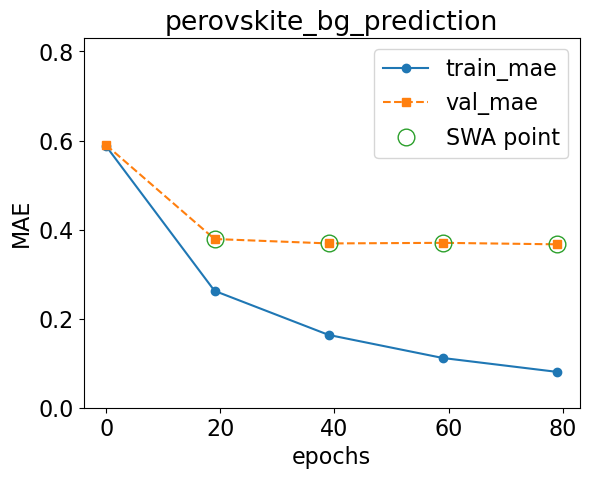

Epoch 99 failed to improve.
Discarded: 1/3 weight updates
Epoch: 99/300 --- train mae: 0.0647 val mae: 0.375


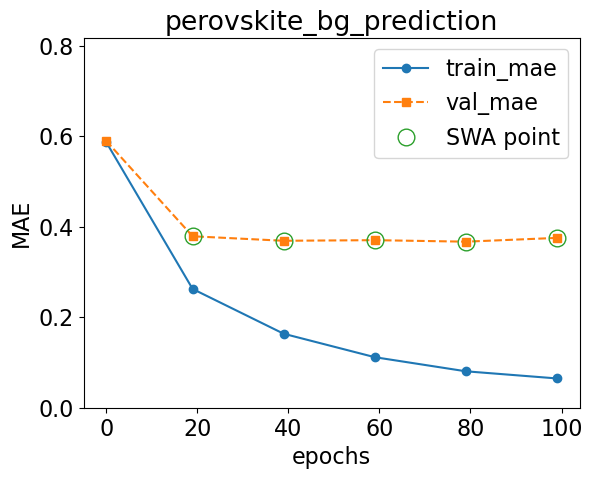

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.056 val mae: 0.375


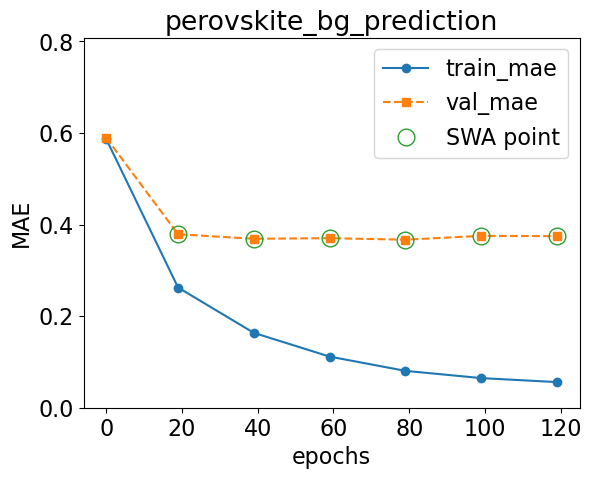

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0514 val mae: 0.374


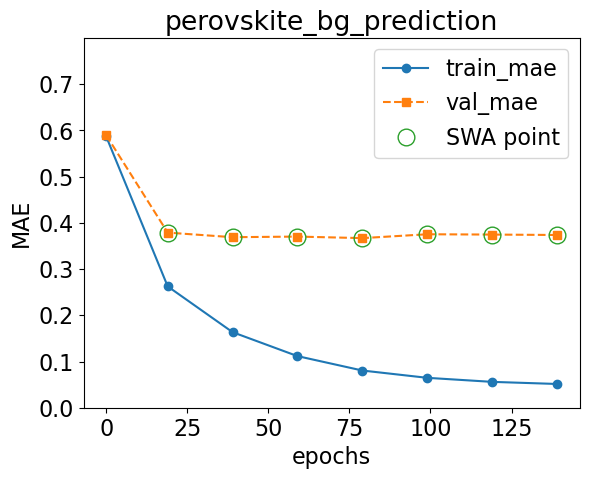

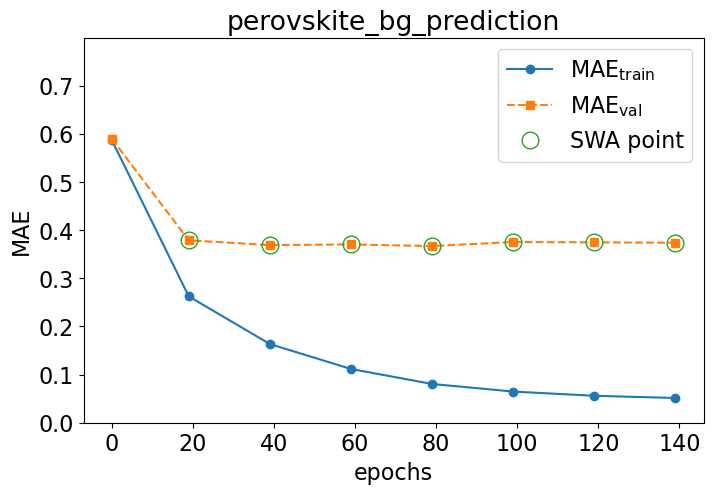

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_prediction) to models/trained_models/perovskite_bg_prediction.pth


In [7]:
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_prediction', elem_prop='mat2vec', learningcurve=True,
                          extend_features=feature_names)
crabnet_bandgap.fit(train_df, val_df)

## Model evaluation

After training, we evaluate the model using the validation data.


Results for source: pvk with data size 798

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 8 elements in the formula


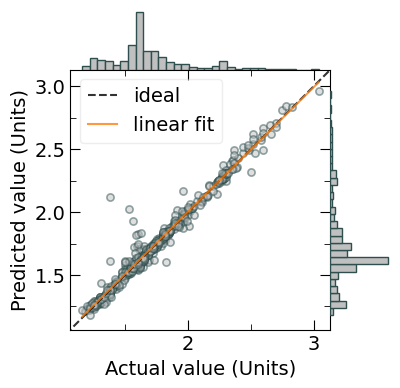

R2 score: 0.9736462183228368
MSE: 0.0023383223711690797
MAE: 0.021377511041026646 eV

Results for source: chalcogenides with data size 9

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 4 elements in the formula


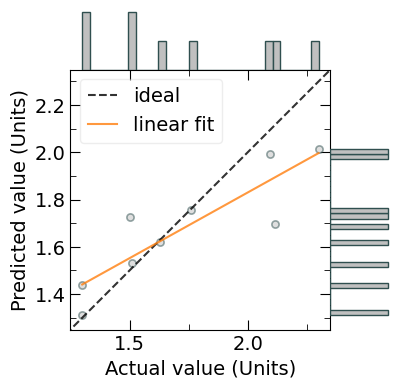

R2 score: 0.6901401799016893
MSE: 0.037456887919550784
MAE: 0.13505365212758377 eV

Results for source: chalc_semicon with data size 2077

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 6 elements in the formula


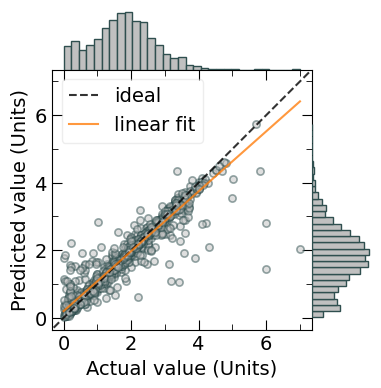

R2 score: 0.9048684771794369
MSE: 0.08185838608633277
MAE: 0.10318644606974586 eV


In [8]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_test_r2_score_by_source_data

# Train data
get_test_r2_score_by_source_data(train_df, df, feature_names)

for validation data we have:


Results for source: pvk with data size 100

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 8 elements in the formula


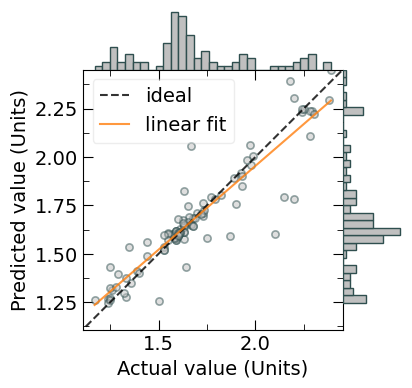

R2 score: 0.8502044358508919
MSE: 0.01258535562571788
MAE: 0.06330915083544376 eV

Results for source: chalcogenides with data size 1

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 3 elements in the formula


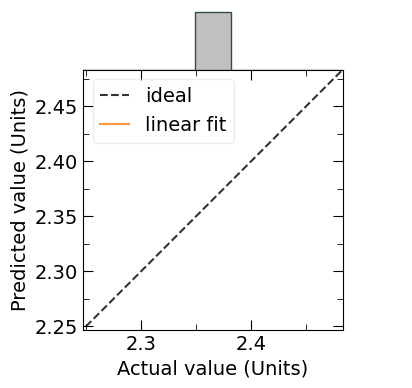

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://

R2 score: nan
MSE: 0.7422562212720532
MAE: 0.8615429306030276 eV

Results for source: chalc_semicon with data size 259

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 259/259 [00:00<00:00, 131246.19formulae/s]


loading data with up to 6 elements in the formula


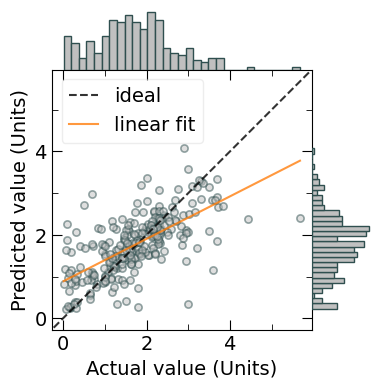

R2 score: 0.4244846014052486
MSE: 0.4981837966454159
MAE: 0.4824926007778949 eV


In [9]:
# Validation data
get_test_r2_score_by_source_data(val_df, df, feature_names)

and finally for test data:


Results for source: pvk with data size 100

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 8 elements in the formula


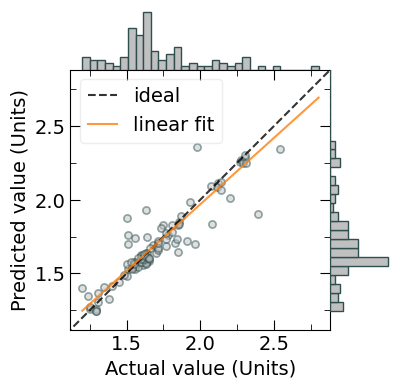

R2 score: 0.8519023037687111
MSE: 0.013265581898687777
MAE: 0.06712581136214374 eV

Results for source: chalcogenides with data size 1

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 3 elements in the formula


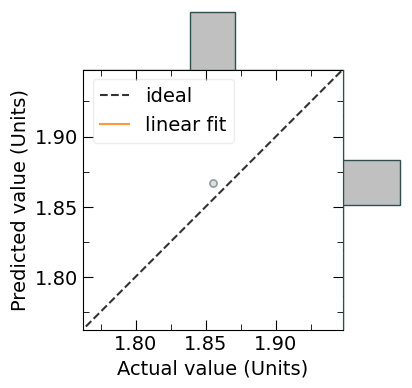

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://

R2 score: nan
MSE: 0.00014711187053856109
MAE: 0.012128968238830584 eV

Results for source: chalc_semicon with data size 260

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 260/260 [00:00<00:00, 231975.97formulae/s]


loading data with up to 6 elements in the formula


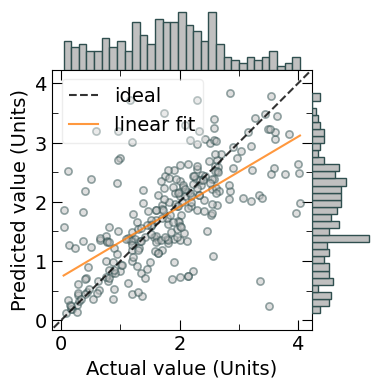

R2 score: 0.344453647256069
MSE: 0.5623030602516224
MAE: 0.5025960339032688 eV


In [10]:
# Test data
get_test_r2_score_by_source_data(test_df, df, feature_names)

Now the error asociated with the complete test data set...


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 8 elements in the formula


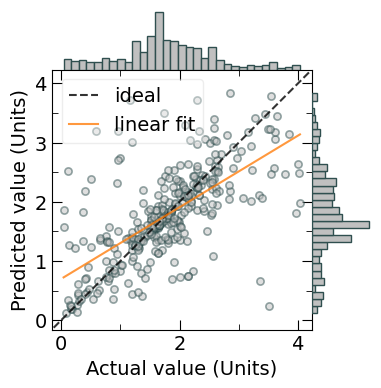

R2 score: 0.3651801698260939
MSE: 0.40865792190604294
MAE: 0.38060853596205757 eV


In [11]:
from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
# Test data
test_r2_score(test_df, feature_names)

## Predict Bandgap from New Formulas

Now we are ready to run some predictions using our trainned model. 

In [1]:
#CrystaLLM data predictions
from tf_chpvk_pv.modeling.CrabNet.utils import get_CrystaLLM_predictions, get_SISSO_predictions, get_experimental_predictions

df_CrystaLLM = get_CrystaLLM_predictions()

#SISSO data predictions

df_SISSO = get_SISSO_predictions()

#Experimentally reported data predictions

df_experimental = get_experimental_predictions()


2025-12-21 16:16:32.287 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network = torch.load(path, map_lo

loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7423.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6710.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1015.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4993.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7358.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2574.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5991.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2777.68formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5017.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4744.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6123.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7884.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1345.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6864.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4519.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4815.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5023.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5511.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6105.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6615.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2138.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4766.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2020.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 796.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7626.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6250.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5475.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2652.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4614.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5809.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3830.41formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8648.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4519.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4271.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4048.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6978.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4619.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7281.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8542.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3679.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6442.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7598.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7612.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3382.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6898.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2328.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3971.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3079.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 134.99formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6864.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4905.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 252.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 458.14formulae/s]


loading data with up to 3 elements in the formula


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4639.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6574.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3603.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1635.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6853.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4744.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3751.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8612.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4236.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9467.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6668.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1028.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5475.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3883.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11335.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5866.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1386.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1274.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5667.98formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8490.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6887.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3410.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3002.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6087.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 923.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3563.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4116.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3844.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3771.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5607.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4266.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7219.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3923.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7219.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9020.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2845.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5562.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7073.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5084.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6355.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1501.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5433.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7543.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4777.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8594.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7194.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3435.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3019.66formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2843.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6195.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3844.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 423.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7397.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4387.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3688.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6678.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7710.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3423.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4821.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 756.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8405.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8719.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6223.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7958.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3600.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1576.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3844.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1602.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6374.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2790.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3102.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5691.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4266.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6432.98formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5152.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3170.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6605.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1361.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 263.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3524.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 184.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3751.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3404.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4619.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4670.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8701.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6472.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3271.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4215.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4040.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7943.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2490.68formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4877.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3090.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9489.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7219.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4206.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7025.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9118.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3396.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5825.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4619.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3983.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2920.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3840.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4793.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6668.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7476.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3175.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7767.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2501.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9078.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 85.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6017.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6168.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4843.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1357.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8811.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4369.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3644.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7752.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1097.99formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5242.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3125.41formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6820.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 172.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7928.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3446.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7096.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3228.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7913.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7530.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7049.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6944.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5047.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7543.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4614.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7182.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4006.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6269.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3840.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5077.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7781.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6543.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5475.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7489.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 857.73formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6533.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5737.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4060.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1608.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4173.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3823.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7973.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3656.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5440.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9258.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7898.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6563.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7839.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7958.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8981.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2953.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6168.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2669.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3371.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6668.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4549.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8065.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7145.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9845.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10255.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8738.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8128.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6732.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1577.99formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2510.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4181.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3524.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1748.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8848.74formulae/s]


loading data with up to 3 elements in the formula


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5071.71formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaZrS3: 1.75 eV
Bandgap prediction for BaZrS3: 1.87 ± 0.11 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7752.87formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaTiS3: 1.3 eV
Bandgap prediction for BaTiS3: 1.44 ± 3.96 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1602.10formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for LaYS3: 2.3 eV
Bandgap prediction for LaYS3: 2.02 ± 0.09 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6297.75formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for CaZrS3: 1.5 eV
Bandgap prediction for CaZrS3: 1.72 ± 0.13 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5165.40formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaZrSe3: 1.3 eV
Bandgap prediction for BaZrSe3: 1.31 ± 0.06 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7002.18formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaHfS3: 2.17 eV
Bandgap prediction for BaHfS3: 1.7 ± 0.17 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10305.42formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped t

loading data with up to 3 elements in the formula
Experimental bandgap for SrZrS3: 2.05 eV
Bandgap prediction for SrZrS3: 1.99 ± 0.12 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4202.71formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for SrHfS3: 2.32 eV
Bandgap prediction for SrHfS3: 1.5 ± 0.26 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8128.50formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 4 elements in the formula
Experimental bandgap for BaZr(S0.6Se0.4)3: 1.76 eV
Bandgap prediction for BaZr(S0.6Se0.4)3: 1.76 ± 0.03 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6114.15formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 4 elements in the formula
Experimental bandgap for Ba(Zr0.95Ti0.05)S3: 1.63 eV
Bandgap prediction for Ba(Zr0.95Ti0.05)S3: 1.62 ± 0.03 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8943.08formulae/s]

loading data with up to 4 elements in the formula
Experimental bandgap for Ba(Zr0.96Ti0.04)S3: 1.51 eV
Bandgap prediction for Ba(Zr0.96Ti0.04)S3: 1.53 ± 0.02 eV


# Training without Chalcogenide perovskites

The shape of the DataFrame is:  (3594, 3)
After cleaning and groupin the data, the sources percentages are:
27.77 % from halide perovskites,
72.23 % from chalcogenide semiconductors

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2875/2875 [00:00<00:00, 105237.37formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 359/359 [00:00<00:00, 139035.56formulae/s]


loading data with up to 8 elements in the formula
stepping every 230 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.587 val mae: 0.605


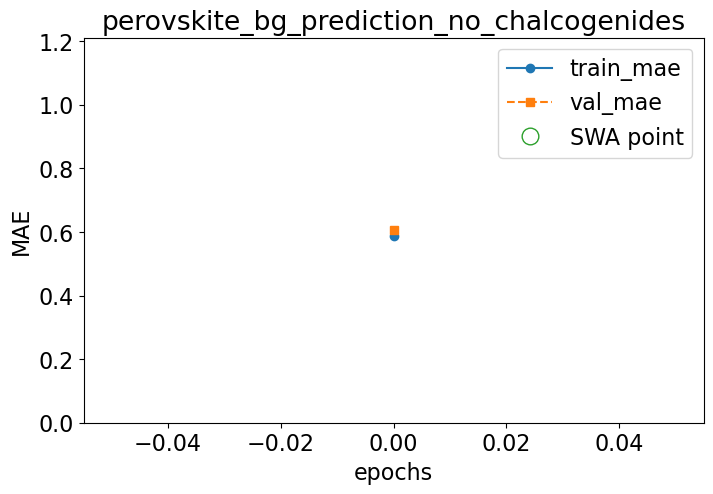

Epoch: 19/300 --- train mae: 0.266 val mae: 0.379


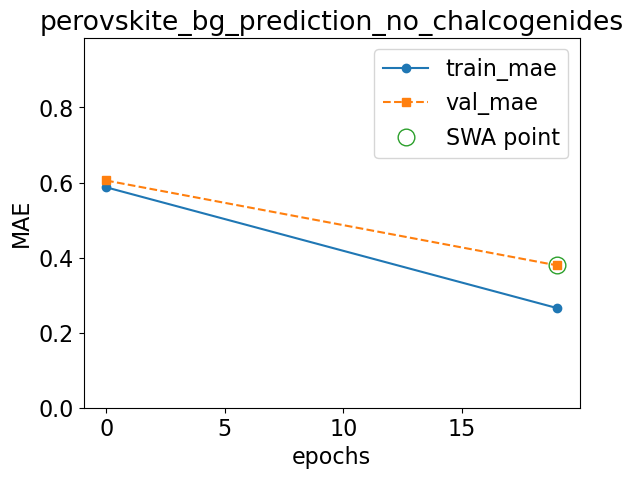

Epoch: 39/300 --- train mae: 0.167 val mae: 0.36


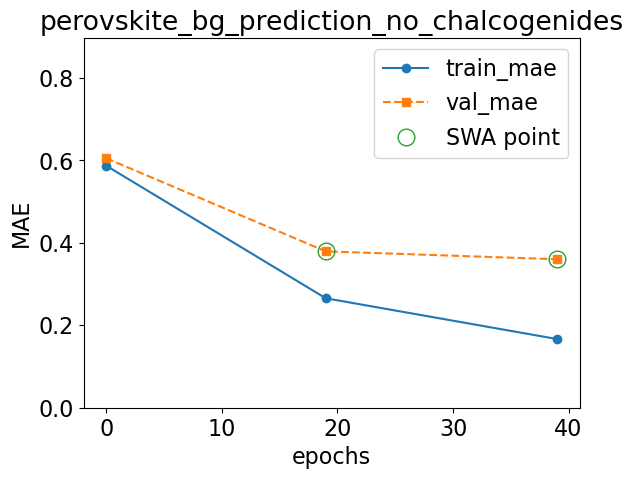

Epoch 59 failed to improve.
Discarded: 1/3 weight updates
Epoch: 59/300 --- train mae: 0.114 val mae: 0.37


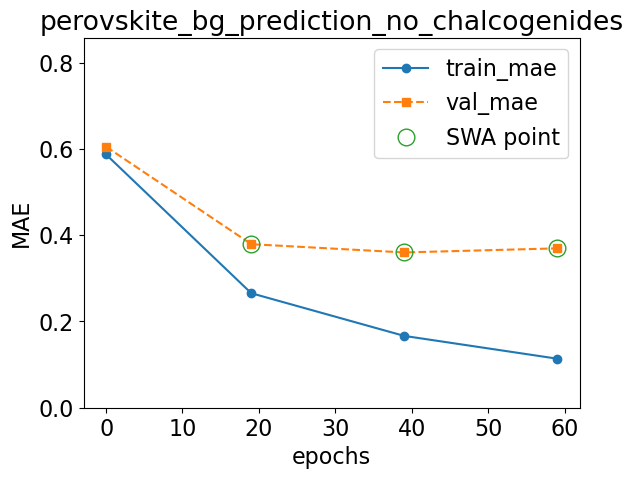

Epoch 79 failed to improve.
Discarded: 2/3 weight updates
Epoch: 79/300 --- train mae: 0.0861 val mae: 0.372


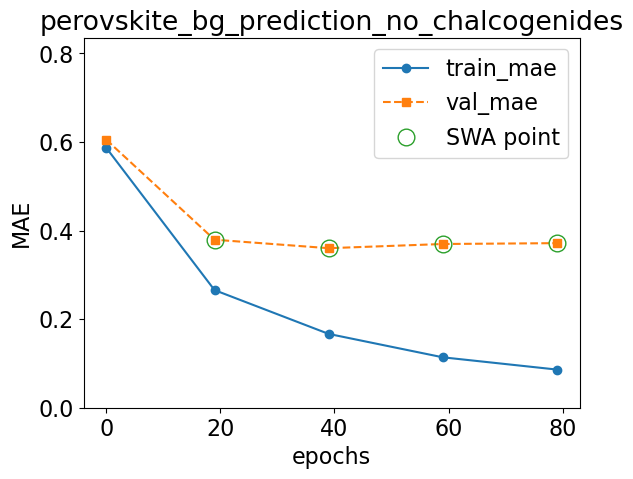

Epoch 99 failed to improve.
Discarded: 3/3 weight updates
Epoch: 99/300 --- train mae: 0.0676 val mae: 0.378


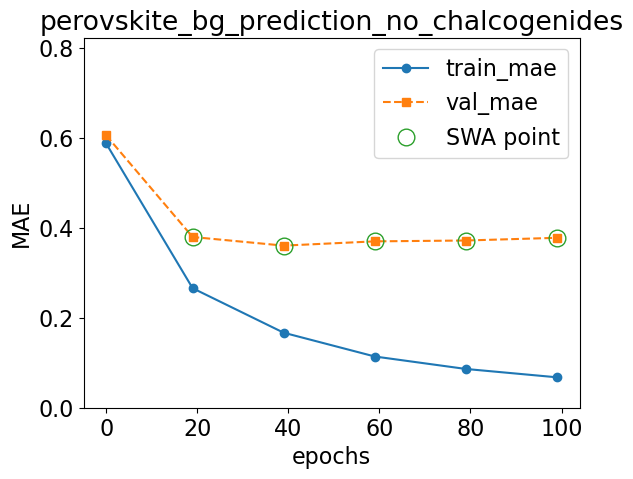

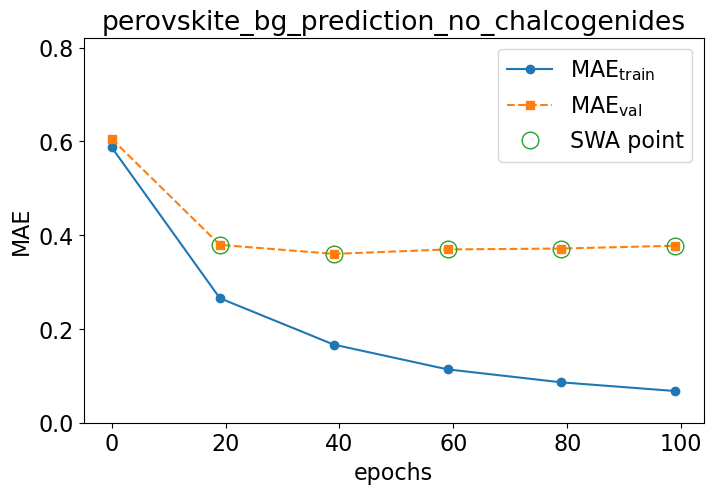

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_prediction_no_chalcogenides) to models/trained_models/perovskite_bg_prediction_no_chalcogenides.pth


In [5]:
df_no_chalcogenides = df[df['source'] != 'chalcogenides'].copy()

from crabnet.utils.data import groupby_formula  # type: ignore
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_no_chalcogenides.rename(columns={'bandgap': 'target'}, inplace=True)
df_no_chalcogenides.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_no_chalcogenides, how='median')

print('The shape of the DataFrame is: ', df_grouped_formula.shape)

for formula in df_grouped_formula['formula']:
    df_grouped_formula.loc[df_grouped_formula['formula'] == formula, 'source'] = df_no_chalcogenides.loc[df_no_chalcogenides['formula'] == formula, 'source'].values[0]

sc_percent = (df_grouped_formula.source.value_counts() / df_grouped_formula.shape[0] * 100).to_dict()
sources = [sc_percent.get(sc) for sc in ['pvk', 'chalc_semicon']]

txt = 'After cleaning and groupin the data, the sources percentages are:' \
      '\n{0:.2f} % from halide perovskites,' \
      '\n{1:.2f} % from chalcogenide semiconductors'.format(*sources)
print(txt)
df_grouped_formula.drop(columns=['source'], inplace=True)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df)

from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_prediction_no_chalcogenides', elem_prop='mat2vec', learningcurve=True,
                          extend_features=feature_names)
crabnet_bandgap.fit(train_df, val_df)

Comparision of predicted and actual values for the chalcogenide perovskite data set, when they are <b>NOT</b> included in the training dataset

The shape of the DataFrame is:  (11, 3)


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 57961.49formulae/s]


loading data with up to 4 elements in the formula


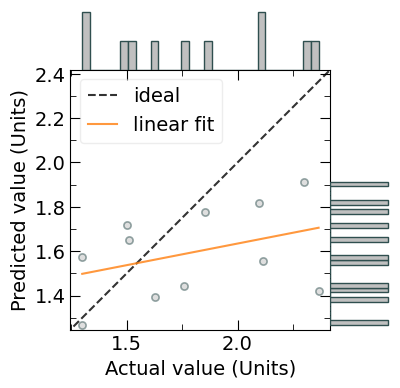

R2 score: -0.18534776035800737
MSE: 0.15761402633018226
MAE: 0.3145831485228105 eV


In [6]:
df_chalcogenides = df[df['source'] == 'chalcogenides'].copy()

# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_chalcogenides.rename(columns={'bandgap': 'target'}, inplace=True)
df_chalcogenides.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_chalcogenides, how='median')

print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

df_test_chalcogenides = get_petiffor_features(df_grouped_formula, original_df=df, train=False)

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS


# Perovskite chalcogenide test data
test_r2_score(df_test_chalcogenides, feature_names,
              model_path = TRAINED_MODELS / 'perovskite_bg_prediction_no_chalcogenides.pth')

Comparision of predicted and actual values for the chalcogenide perovskite data set, when they <b>are</b> included in the training dataset


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 4 elements in the formula


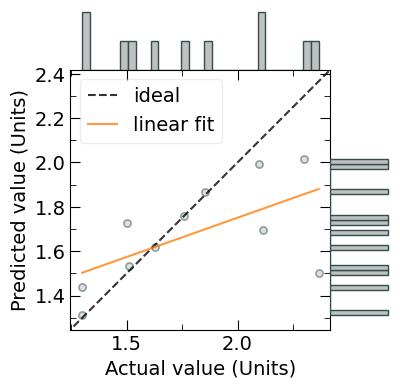

R2 score: 0.2619478551696768
MSE: 0.09813775676532263
MAE: 0.18992316072637383 eV


In [7]:
# Perovskite chalcogenide test data
test_r2_score(df_test_chalcogenides, feature_names,
              model_path = TRAINED_MODELS / 'perovskite_bg_prediction.pth')

In [8]:
def mean_absolute_error(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Input lists must have the same length.")
    errors = [abs(t - p) for t, p in zip(y_true, y_pred)]
    return sum(errors) / len(errors)

MAE_null = mean_absolute_error(df_chalcogenides['target'], df_chalcogenides['target'].mean().repeat(df_chalcogenides.shape[0]))

print('Mean Absolute Error (MAE) null model for chalcogenide perovskites: {:.4f} eV'.format(MAE_null))

Mean Absolute Error (MAE) null model for chalcogenide perovskites: 0.2845 eV
